Upon looking through the dataset we discovered that there were some duplicate boxes. When you run the ```preprocess.py``` script contained in the previous cohort's repo, the number of labels does not match up to the number of image crops. Upon investigating this we found that some bounding boxes were duplicates (bounding the same person with very similar coordinates/sizes and sometimes the same labels). This is obviously a huge problem as you may be leaking training data in to the test/validation set with these duplicate boxes. The previous cohort (either deliberately or by accident, not sure) solved this by only taking one bounding box per image regardless of how many there are. This notebook goes through the thought process and the detection of duplicate bboxes.

In [89]:
from pathlib import Path
from PIL import Image, ImageDraw
from random import choice
from itertools import compress
import glob
import os

import pandas as pd
import numpy as np

from IPython.display import display

In [2]:
data_root_dir = Path( "/home/lewis/Work/Employment/fellowshipai/fashion/data/streetstyle/" )
image_dir = data_root_dir/"streetstyle27k"

new_dir = data_root_dir/"streetstyle27k_cropped"
old_dir = data_root_dir/"streetstyle27k_cropped_old"

new_csv = data_root_dir/"ss27k_labels.csv"
old_csv = data_root_dir/"streetstyle27k.preprocessed.labels.csv"

manifest = data_root_dir/"streetstyle27k.manifest"

In [3]:
old_df, new_df, manifest_df = pd.read_csv( old_csv ), pd.read_csv( new_csv ), pd.read_csv( manifest )

In [4]:
print( len( manifest_df ) )
print( len( old_df ) )
print( len( new_df ) )

27087
27087
27087


Here, we are using the ```manifest_df``` which is the dataframe for the original streetstyle manifest file (csv), the ```old_df``` which is the dataframe generated from the previous cohort's ```preprocess.py``` script and the ```new_df``` which is the dataframe generated from our ```preprocess.py``` script.

As we can see, all three files have the same number of labels

In [5]:
old_df.head()

,images,label
0,/home/lewis/Work/Employment/fellowshipai/fashi...,clothing_pattern_solid major_color_red wearing...
1,/home/lewis/Work/Employment/fellowshipai/fashi...,clothing_pattern_graphics major_color_white we...
2,/home/lewis/Work/Employment/fellowshipai/fashi...,clothing_pattern_floral major_color_multicolor...
3,/home/lewis/Work/Employment/fellowshipai/fashi...,clothing_pattern_solid major_color_black weari...
4,/home/lewis/Work/Employment/fellowshipai/fashi...,clothing_pattern_solid major_color_blue wearin...


In [131]:
sorted_old_dupes = old_df[old_df.duplicated( subset="images", keep=False ) == True].sort_values( "images" )
sorted_old_dupes["images"] = sorted_old_dupes["images"].apply( lambda x: x.replace( "/home/lewis/Work/Employment/fellowshipai/fashion/data/streetstyle/streetstyle27k_cropped", "" ) )
sorted_old_dupes.head()

,images,label
20754,/0/0/0/000dc542b6bbea2e53527d5dedb0ed72_584505...,clothing_pattern_solid major_color_pink wearin...
9208,/0/0/0/000dc542b6bbea2e53527d5dedb0ed72_584505...,clothing_pattern_no_label major_color_pink wea...
21655,/0/0/2/002f06f08d4a02fd02b00af1e75f8c7d_740688...,clothing_pattern_graphics major_color_black we...
12686,/0/0/2/002f06f08d4a02fd02b00af1e75f8c7d_740688...,clothing_pattern_solid major_color_white weari...
9165,/0/0/3/0039c332225df6a6b07910c842b1b9bb_100862...,clothing_pattern_solid major_color_white weari...


In [6]:
print( len( manifest_df["url"].unique() ) )
print( len( old_df["images"].unique() ) )
print( len( new_df["image"].unique() ) )

23908
23908
27087


Here we get a difference. As you would expect, there are less unique images than there are labels in the ```manifest_df``` since there can be multiple bounding boxes per image (duplicates or multiple people). The same is replicated in the ```old_df``` except here, there are multiple labels referring to the same image. This is fine if the image is not cropped, although its not ideal. If you crop the images using the (first) bounding box then you have multiple (potentially different) labels referring to the same image, as you can see above in ```sorted_old_dupes.head()```.

What we do instead is save each cropped image as a separate file so each label corresponds to exactly one image.

In [7]:
print( len( [ filename for filename in glob.iglob( str( new_dir ) + '/**/*.jpg', recursive=True ) ] ) )
print( len( [ filename for filename in glob.iglob( str( old_dir ) + '/**/*.jpg', recursive=True ) ] ) )

27087
23908


In [124]:
len( manifest_df["id"].unique() )

27087

In [8]:
dupes = manifest_df[manifest_df.duplicated( subset="url", keep=False ) == True]
dupes.head()

,id,url,created_time,city_id,month_id,lat,long,x1,y1,x2,...,wearing_necktie,collar_presence,wearing_scarf,sleeve_length,neckline_shape,clothing_category,wearing_jacket,wearing_hat,wearing_glasses,multiple_layers
7,3749345,https://s3.amazonaws.com/stylyze/3298b741dfda0...,2014-05-22 07:16:39+00,18.0,2014_5,18.970790,72.838393,65,159,187,...,No,No,No,Short sleeve,Round,T-shirt,No,No,No,One layer
51,3730422,https://s3.amazonaws.com/stylyze/8bca249fda413...,2014-11-05 09:33:08+00,2.0,2014_11,39.914284,116.419060,410,270,470,...,No,NaN,No,Long sleeve,NaN,Outerwear,Yes,No,No,One layer
54,24269,https://s3.amazonaws.com/stylyze/fb4f21ff3c993...,2014-09-16 06:52:12+00,17.0,2014_9,19.433300,-99.133300,214,117,286,...,Yes,Yes,No,Long sleeve,Folded,Suit,Yes,No,No,Multiple layers
209,8956751,https://s3.amazonaws.com/stylyze/c36d98a92dc04...,2015-10-10 12:26:22+00,32.0,2015_10,47.496283,19.039650,445,151,585,...,No,NaN,No,Long sleeve,Round,NaN,Yes,No,No,Multiple layers
211,8958970,https://s3.amazonaws.com/stylyze/16d3a5e3ede48...,2015-04-12 07:41:53+00,34.0,2015_4,42.694960,23.325451,128,158,203,...,No,NaN,No,Long sleeve,Folded,Outerwear,Yes,No,No,Multiple layers


In [9]:
len( dupes )

5872

So we have 5872 images that have more than one label. This is not necessarily a duplicate bounding box (ignore the bad naming scheme) as it could refer to an image with multiple people, each with their own bounding box. We find that this is sometimes the case but also a lot of the time it isn't.

In [108]:
dupes = dupes.fillna("no_label")

In [78]:
## taken from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation

def get_modified_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # if one of the boxes completely contains the other box, we will
    # return 1. this is not strictly IoU but it works a bit better for
    # our needs
    if intersection_area == bb1_area or intersection_area == bb2_area:
        return 1.0
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

To quantify what a 'duplicate' bounding box actually is, we're using a modified IoU score. IoU essentially computes the ratio of how much of each box's area is intersecting over their total combined area. This is not fully what we want, as some boxes fully contain other boxes and the IoU in that case is not ```==1``` as we want. We therefore modify the score to output 1 if the intersection area is exactly equal to either of the boxes areas. 

Our logic here is that if one box fully contains another, in the case they have the same labels we are just duplicating data and in the case where they have different labels, the larger boxed crop acts as noise when fed through the classifier as it also contains whatever different labels the smaller box had (e.g. if the larger box is a adult and the smaller box is a child standing in front of them, the adult wearing a jumper and the child wearing a t-shirt, running the larger box through the classifier with ```clothing_category_t-shirt``` set to false confuses the classifier - the meta features that it learned correlate with the ```clothing_category_t-shirt``` class become less accurate).

We additionally define a threshold for when one box does not fully contain the other. Anything above this threshold we define as a duplicate. If the boxes do not intersect at all, or only intersect slightly, the IoU score will be far below the threshold - this likely represents the multiple people case.

In [109]:
threshold = 0.9
label_cols = ['clothing_pattern', 'major_color', 'wearing_necktie', 'collar_presence', 
              'wearing_scarf', 'sleeve_length', 'neckline_shape', 'clothing_category', 
              'wearing_jacket', 'wearing_hat', 'wearing_glasses', 'multiple_layers']

In [110]:
done = set()
possible_dupes = dict()
for _, item in dupes.iterrows():
    if item["url"] in done:
        continue
    else:
        done.add( item["url"] )
        
    fn = os.path.basename( item["url"] )
    im_path = os.path.join( fn[0], fn[1], fn[2], fn ) 
        
    item_dupes = dupes.loc[dupes["url"] == item["url"]]
    item_bboxes = [ { "x1": bbox[0], "x2": bbox[1], "y1": bbox[2], "y2": bbox[3] } 
                   for bbox in item_dupes[["x1","x2","y1","y2"]].to_numpy() ]
    item_bboxes_index = [ ind for ind in item_dupes[["id"]].to_numpy() ]
    item_bboxes_classes = [ dict( zip( label_cols, cols ) ) for cols in item_dupes[label_cols].to_numpy() ]
    
    high_iou = list()
    for n, bbox in enumerate( item_bboxes ):
        for n2, bbox2 in enumerate( item_bboxes[n+1:] ):
            iou = get_modified_iou( bbox, bbox2 )
            if iou > threshold:
                item2_labels = item_bboxes_classes[n+n2+1]
                label_match = all( [ v == item2_labels[k] for k, v in item_bboxes_classes[n].items() ] )
                high_iou.append( [ item_bboxes_index[n][0], item_bboxes_index[n+n2+1][0], iou, label_match ] )
                
    if len( high_iou ):
        possible_dupes[im_path] = high_iou

In [111]:
total, true = 0, 0
for k, v in possible_dupes.items():
    total += len( v )
    for pair in v:
        if pair[3]: true += 1
            
print( total, true )

1059 370


After scoring all bounding boxes, we find that there are 1059 duplicate pairs, of which 370 share the same labels.

Modified IoU: 1.0 for black rectangles. LabelsMatch=False
Mismatched on multiple_layers: One layer/no_label


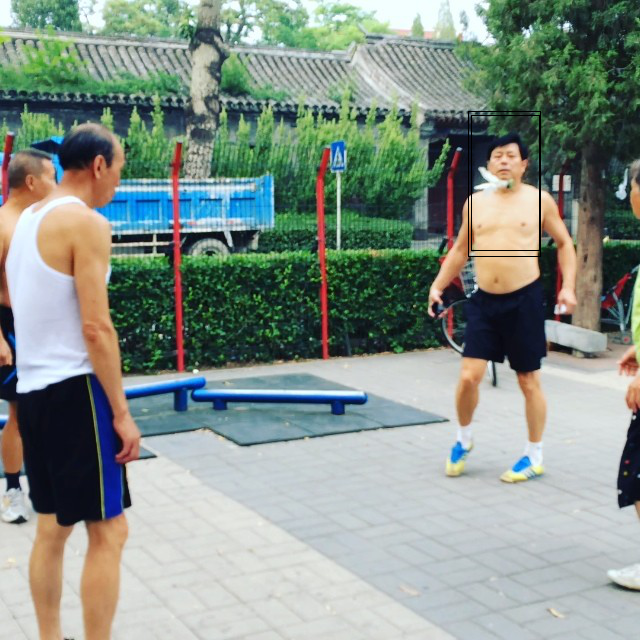

In [133]:
colors = [ "black", "green", "blue", "red", "orange", "white" ]

image = choice( list( possible_dupes.keys() ) )
high_iou = possible_dupes[image]

im = Image.open( image_dir/image )
for n, pair in enumerate( high_iou ):
    images_df = dupes.loc[( dupes["id"] == pair[0] ) | ( dupes["id"] == pair[1] )][["x1","x2","y1","y2"] + label_cols]
    print( "Modified IoU: {} for {} rectangles. LabelsMatch={}".format( round( pair[2], 3 ), colors[n], pair[3] ) )
    
    if not pair[3]:
        matches = [ not i for i in ( images_df.iloc[[0]][label_cols].to_numpy() == images_df.iloc[[1]][label_cols].to_numpy() )[0] ]
        mismatches = compress( label_cols, matches )
        for col in mismatches:
            print( "Mismatched on {}: {}/{}".format( col, images_df.iloc[[0]][col].values[0], images_df.iloc[[1]][col].values[0] ) )
    
    for _, item in images_df.iterrows():
        draw = ImageDraw.Draw( im )
        draw.rectangle( [ item["x1"], item["y1"], item["x2"], item["y2"] ], outline=colors[n] )

display( im )

If you keep rerunning this code you will get different images. As you can see the bounding boxes are either totally contained or have very high intersection. When the labels do not agree, often its that one labeller did not label that attribute (```no_label```) or they disagree on the correct attribute (```v-neck``` vs ```collar```). In either case, and even if the labels agree, we discard all duplicates. We could define some heuristics to decide which box to keep (e.g. ```label``` > ```no_label```) but we risk introducing more noise if we decide badly. We could fairly easily discard all bounding boxes but one for the case where the labels agree, but there are only ~300 images that satisfy this criteria and, at least right now, its not worth the extra effort.

In [122]:
ignored = set()

with open( data_root_dir/"dupe_ignores.csv", "w") as f:
    f.write( "id,image\n" )
    for k, v in possible_dupes.items():
        for pair in v:
            pid1, pid2 = pair[0], pair[1]
            
            if pid1 not in ignored:
                f.write( "{},{}\n".format( pid1, k ) )
                ignored.add( pid1 )
                
            if pid2 not in ignored:
                f.write( "{},{}\n".format( pid2, k ) )
                ignored.add( pid2 )

print( len( ignored ) )

1880


In the end, we discard 1880 bounding boxes from our dataset. In theory, the remaining examples should neither contain duplicates (bad for data leakage) or labels referring to incorrect bounding box crops (noise).